In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mcmclib.metropolis import mala_adapt
from mcmctoolbox.mcmc import MCMC
from mcmctoolbox.functoolbox import flat

import os
import json
import pandas as pd
import bridgestan as bs
from posteriordb import PosteriorDatabase

import nest_asyncio
nest_asyncio.apply()

np.random.seed(1234)

In [2]:
# Load DataBase Locally
pdb_path = os.path.join("../../posteriordb/posterior_database")
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-banana-test-banana")
stan_file_path = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan_file_path, data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]

In [3]:
alpha = 10 * [0.3]
epoch = 9 * [1_000] + [91_000]
x, _, _, _, _, _ = mala_adapt(
    fp=log_p,
    fg=grad_log_p,
    x0=np.array([0., 0.]),
    h0=0.1,
    c0=np.eye(2),
    alpha=alpha,
    epoch=epoch,
    pb=True)

100%|██████████| 9/9 [00:16<00:00,  1.83s/it]


In [4]:
MALAout = np.concatenate(x)
np.savetxt('Data/banana_MALA.csv', MALAout, delimiter=',')

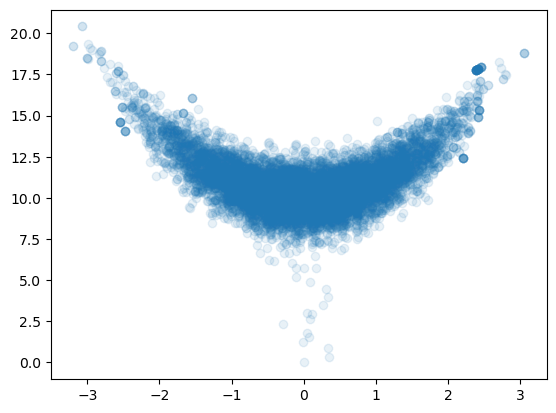

In [5]:
plt.plot(MALAout[::10, 0], MALAout[::10, 1], 'o', alpha=0.1)
plt.savefig('Pic/banana_MALA.png', dpi=300)

del MALAout

In [6]:
fisher_mala = MCMC(log_p, grad_log_p, nits=100_000, theta_start=np.array([0., 0.]))
fisher_mala.fisher_adaptive_mala()
np.savetxt('Data/banana_fisher_MALA.csv', fisher_mala.store, delimiter=',')

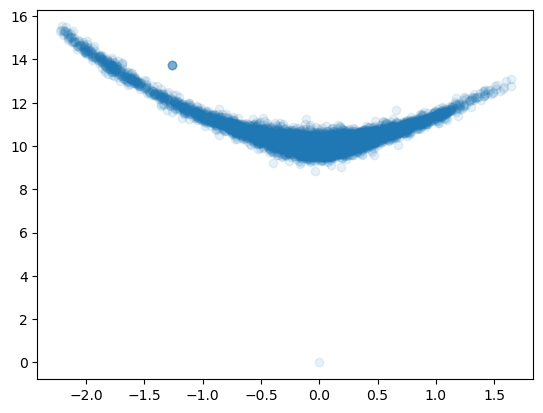

In [7]:
plt.plot(fisher_mala.store[::10, 0], fisher_mala.store[::10, 1], 'o', alpha=0.1)
plt.savefig('Pic/banana_fisher_MALA.png', dpi=300)

del fisher_mala

In [8]:
mh_rwm = MCMC(log_p, grad_log_p, nits=100_000, theta_start=np.array([0., 0.]))
mh_rwm.rwm(epsilon=2.38**2)
np.savetxt('Data/banana_rwm.csv', mh_rwm.store, delimiter=',')

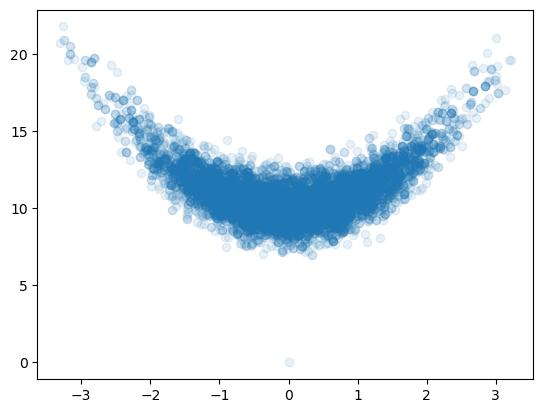

In [9]:
plt.plot(mh_rwm.store[::10, 0], mh_rwm.store[::10, 1], 'o', alpha=0.1)
plt.savefig('Pic/banana_rwm.png', dpi=300)

del mh_rwm